## Submission Sistem Rekomendasi : Arliyandi ##

### Load Library

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer
import pickle

## Data Exploration ##

In [33]:
df = pd.read_csv('laptops.csv')
df.head()


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


Dataset yang digunakan berisi informasi spesifikasi laptop dari berbagai merek dan model. Total terdapat 2160 entri data, masing-masing memiliki 12 fitur.

Beberapa fitur utama pada dataset meliputi:
- Brand, Model, CPU, GPU: Informasi spesifikasi hardware
- RAM, Storage, Storage type, Screen, Touch: komponen teknis
- Final Price: Harga akhir laptop.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


Dari hasil eksplorasi awal:

- Jumlah data: 2160 baris
- Jumlah kolom: 12 fitur.
- terdapat beberapa kolom yang kosong, dan perlu penyesuaian di proses cleaning nantinya

In [35]:
df.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


Hasil analisis deskriptif menunjukkan variasi spesifikasi:
- RAM berkisar antara 4GB hingga 128GB, dengan median di 16GB
- Kapasitas storage mulai dari 0GB (kemungkinan error entri) hingga 4TB.
- Ukuran layar (screen) dominan di sekitar 15.6 inci
- Harga laptop bervariasi cukup lebar, mulai dari sekitar $201 hingga $7150

In [36]:
df.isnull().sum()

Laptop             0
Status             0
Brand              0
Model              0
CPU                0
RAM                0
Storage            0
Storage type      42
GPU             1371
Screen             4
Touch              0
Final Price        0
dtype: int64

Berdasarkan informasi diatas, terdapat beberapa fitur yang memiliki missing calue :
- Storage type: 42 missing value
- GPU: 1371 missing value
- Screen: 4 missing value

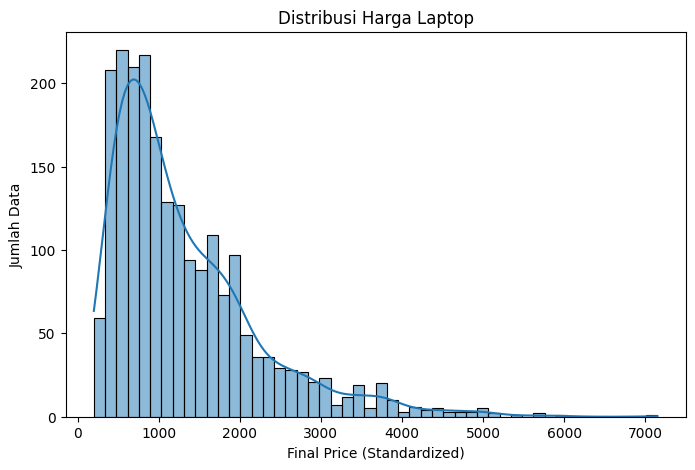

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(df['Final Price'], bins=50, kde=True)
plt.title('Distribusi Harga Laptop')
plt.xlabel('Final Price (Standardized)')
plt.ylabel('Jumlah Data')
plt.show()

Dapat kita perhatikan, sebaran harga laptop paling banyak di harga $500 - $1500

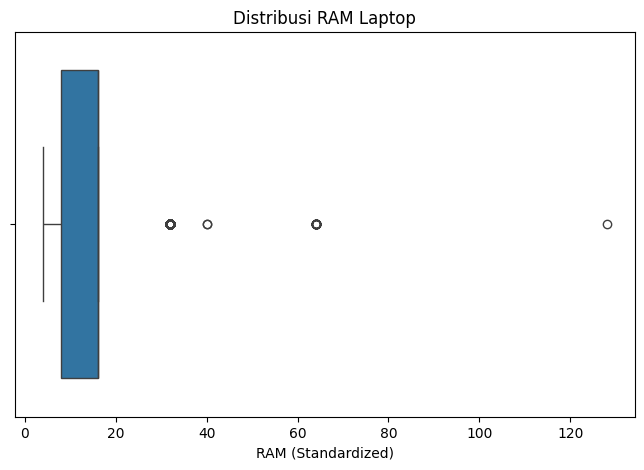

In [38]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['RAM'])
plt.title('Distribusi RAM Laptop')
plt.xlabel('RAM (Standardized)')
plt.show()

Untuk Ram, Distribusi size nya paling banyak di 8 - 16 Gb

## Data Cleaning ##

In [39]:
df = df.drop(columns=['Laptop', 'Status'])

Drop kolom Laptop dan status karena tidak berkaitan denan model nantinya

In [40]:
df['Storage type'].fillna(df['Storage type'].mode()[0], inplace=True)

C:\Users\Vrooh\AppData\Local\Temp\ipykernel_18248\922764840.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Storage type'].fillna(df['Storage type'].mode()[0], inplace=True)


Isi storage Type dengan mode, untuk mengatasi missing value. Metode ini dipilih karena missing value tidak terlalu banyak dan tipe gpu tidak terlalu banyak berdampak besar pada seharusnya pada model

In [41]:
df['GPU'].fillna('Unknown', inplace=True)

C:\Users\Vrooh\AppData\Local\Temp\ipykernel_18248\3843799078.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GPU'].fillna('Unknown', inplace=True)


Untuk GPU, missing value kita isi dengan 'unknown'. Bisa juga diisi dengan Integrated, tapi karena value awalnya memang kosong jadi lebih aman saya isi dengan unknown.

In [42]:
df['Screen'].fillna(df['Screen'].median(), inplace=True)

C:\Users\Vrooh\AppData\Local\Temp\ipykernel_18248\1750864341.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Screen'].fillna(df['Screen'].median(), inplace=True)


## Data Preparation ##

In [43]:
categorical_cols = ['Brand', 'Model', 'CPU', 'Storage type', 'GPU', 'Touch']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Fitur kategorikal seperti Brand, Model, CPU, Storage type, GPU, dan Touch tidak dapat langsung digunakan dalam bentuk string. Oleh karena itu, diterapkan proses encoding menggunakan 'Label Encoding' untuk mengubah nilai string menjadi numerik.

In [44]:
# Scaling numerik
numerical_cols = ['RAM', 'Storage', 'Screen', 'Final Price']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Beberapa fitur numerik memiliki skala yang sangat bervariasi (misalnya: RAM, Storage, dan Final Price). Untuk menyamakan skala dan menghindari dominasi fitur tertentu pada perhitungan similarity, diterapkan 'Standard Scaler' sehingga setiap fitur memiliki mean = 0 dan standar deviasi = 1.

In [45]:
print(df.head())
print(df.info())
print(df.describe())

   Brand  Model  CPU       RAM   Storage  Storage type  GPU    Screen  Touch  \
0      3     42   17 -0.751494 -0.233414             0   44  0.358619      0   
1      1     54   14 -0.751494 -0.942287             0   44  0.358619      0   
2      3     42   16 -0.751494 -0.942287             0   44  0.358619      0   
3     14     58   18  0.059410  1.117874             0   17  0.358619      0   
4      9      4   17  0.059410 -0.233414             0   44  0.358619      0   

   Final Price  
0    -0.333206  
1    -1.112343  
2    -0.574629  
3    -0.124704  
4    -0.706303  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         2160 non-null   int32  
 1   Model         2160 non-null   int32  
 2   CPU           2160 non-null   int32  
 3   RAM           2160 non-null   float64
 4   Storage       2160 non-null   float64
 5   Stor

Setelah dilakukan encoding dan scaling:
- Dataset memiliki total 2160 baris dan 10 kolom.
- Semua data siap diproses ke tahap modeling
- Tidak ada lagi missing value setelah tahap data cleaning sebelumnya.

In [46]:
# Siapkan fitur untuk similarity
feature_cols = categorical_cols + numerical_cols
features = df[feature_cols].values


## Modelling ##

### Content Based Filtering ###

In [47]:
# Hitung cosine similarity
similarity = cosine_similarity(features)

In [48]:
# Fungsi rekomendasi
def recommend(index, top_n=5):
    score = list(enumerate(similarity[index]))
    score = sorted(score, key=lambda x: x[1], reverse=True)
    score = score[1:top_n+1]
    indices = [i[0] for i in score]
    return df.iloc[indices]

In [49]:
print("Rekomendasi untuk data ke-10:")
print(recommend(10))

Rekomendasi untuk data ke-10:
      Brand  Model  CPU       RAM   Storage  Storage type  GPU    Screen  \
1581     13    108   14 -0.751494 -0.942287             0   44  0.358619   
456      13    108   14 -0.751494 -0.942287             0   44  0.358619   
1192     13    108   14 -0.751494 -0.942287             0   44  0.358619   
1582     13    108   14 -1.156946 -0.942287             0   44  0.358619   
686      13    108   14 -1.156946 -1.296723             0   44  0.358619   

      Touch  Final Price  
1581      0    -1.067592  
456       0    -1.086566  
1192      0    -0.989437  
1582      0    -1.044306  
686       0    -1.134290  


Sistem berhasil merekomendasikan produk dengan spesifikasi yang hampir identik dari sisi:
Brand (sama-sama kode 13, artinya sama brandnya)
Model (kode 108, model juga sama)
CPU (kode 14, prosesor sama)
Storage type, GPU, Touch, Screen, semuanya sama.

Variasi utama hanya sedikit pada:

RAM -> ada perbedaan kecil (contoh: -0.751 vs -1.156 → berarti mungkin beda 8GB vs 16GB jika sebelum di scaling).

Storage -> sebagian besar sama, hanya 1 data dengan storage sedikit lebih rendah (perbedaan minor).

Final Price -> harga bervariasi tipis, semua tetap dalam range mirip.

Sistem merekomendasikan laptop yang sangat mirip dengan target (spesifikasi utama tetap sama), namun ada sedikit variasi di kapasitas RAM, Storage, dan harga. Ini sesuai ekspektasi dari sistem content-based filtering.

### Collaborative Filtering ###

In [51]:
def recommend_collaborative(index, top_n=5):
    scores = list(enumerate(similarity[index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:top_n+1]
    indices = [i[0] for i in scores]
    return df.iloc[indices]

In [52]:
print("Collaborative Filtering Recommendation (index 10):")
print(recommend_collaborative(10))

Collaborative Filtering Recommendation (index 10):
      Brand  Model  CPU       RAM   Storage  Storage type  GPU    Screen  \
1581     13    108   14 -0.751494 -0.942287             0   44  0.358619   
456      13    108   14 -0.751494 -0.942287             0   44  0.358619   
1192     13    108   14 -0.751494 -0.942287             0   44  0.358619   
1582     13    108   14 -1.156946 -0.942287             0   44  0.358619   
686      13    108   14 -1.156946 -1.296723             0   44  0.358619   

      Touch  Final Price  
1581      0    -1.067592  
456       0    -1.086566  
1192      0    -0.989437  
1582      0    -1.044306  
686       0    -1.134290  


Collaborative Filtering menghasilkan rekomendasi yang sangat mirip dengan Content-Based Filtering dalam kasus dataset ini.
Hal ini terjaid karena kedua pendekatan menggunakan sumber data spesifikasi produk yang sama, hanya berbeda dari cara perspektif pendekatannya (fitur produk vs relasi antar item).